## Done by -> <em style="color: #4FAEB0; font-size: 24px;">Abhishek Kulkarni</em>

In [6]:
# Importing necessary modules and libraries
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import os.path
import IPython.display
import IPython.display as ipd
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from pathlib import Path
from scipy.io import wavfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers
from keras.utils import np_utils
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau

import warnings

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
# set directory path
audio_directory = Path('/kaggle/input/speech-emotion-recognition-en/Crema')

In [8]:
file_path = list(audio_directory.glob(r'**/*.wav')) # setting file path

In [9]:
Label = list(map(lambda x: os.path.split(x)[1].split('_')[2], file_path))
set(Label)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

**These correspond to the emotions:**

* ANG: Anger 😡
* DIS: Disgust 🤢
* FEA: Fear 😱
* HAP: Happiness 😀
* NEU: Neutral 😐
* SAD: Sadness 😭

In [10]:
file_path = pd.Series(file_path, name='file_path').astype(str)
Label = pd.Series(Label, name='label')

audio_df = pd.concat([file_path, Label], axis=1)
audio_df

,file_path,label
0,/kaggle/input/speech-emotion-recognition-en/Cr...,DIS
1,/kaggle/input/speech-emotion-recognition-en/Cr...,HAP
2,/kaggle/input/speech-emotion-recognition-en/Cr...,HAP
3,/kaggle/input/speech-emotion-recognition-en/Cr...,DIS
4,/kaggle/input/speech-emotion-recognition-en/Cr...,DIS
...,...,...
7437,/kaggle/input/speech-emotion-recognition-en/Cr...,ANG
7438,/kaggle/input/speech-emotion-recognition-en/Cr...,ANG
7439,/kaggle/input/speech-emotion-recognition-en/Cr...,ANG
7440,/kaggle/input/speech-emotion-recognition-en/Cr...,SAD


<Axes: xlabel='label', ylabel='Count'>

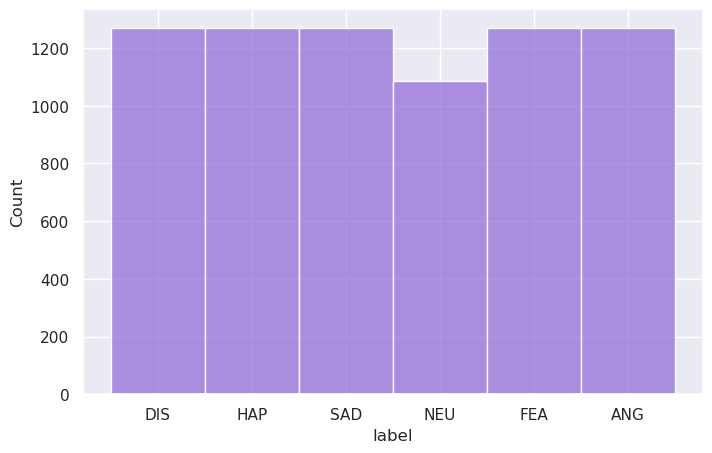

In [14]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('darkgrid')
sns.histplot(Label, color='#9370DB')

In [11]:
def samples(df):
    # Shuffle the DataFrame
    shuffle_df = df.sample(frac=1).reset_index(drop=True)

    # Iterate over unique Label in the shuffled DataFrame
    for label in shuffle_df['label'].unique():
        # Filter DataFrame for the current label
        label_df = shuffle_df[shuffle_df['label'] == label].head(1)  # Take the first example for each label

        # ext file path and label
        file_path = label_df['file_path'].values[0]
        label = label_df['label'].values[0]

        # Load audio file using librosa
        audio, sr = librosa.load(file_path)

        # Generate the time axis for the waveform
        duration = len(audio) / sr
        time = librosa.times_like(audio, sr=sr)

        # Plot waveform
        plt.plot(time, audio, color='#DC143C')
        plt.title(f'Waveform for {label}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()
        print()
        
        # Play the audio
        ipd.display(ipd.Audio(audio, rate=sr))
        print()
        print()

**visualizing the emotions**

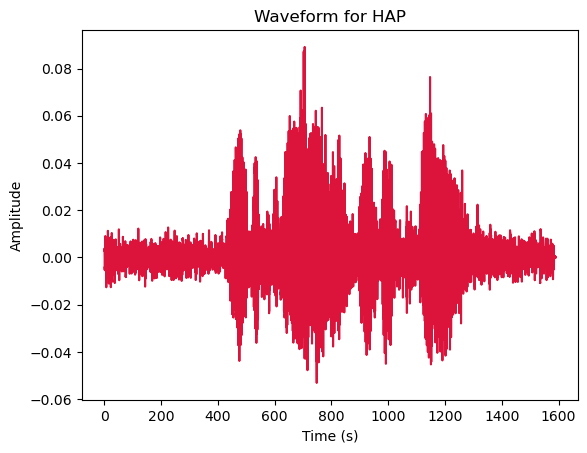

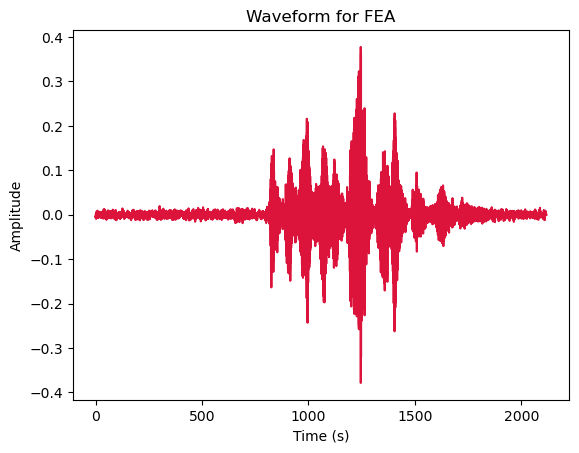

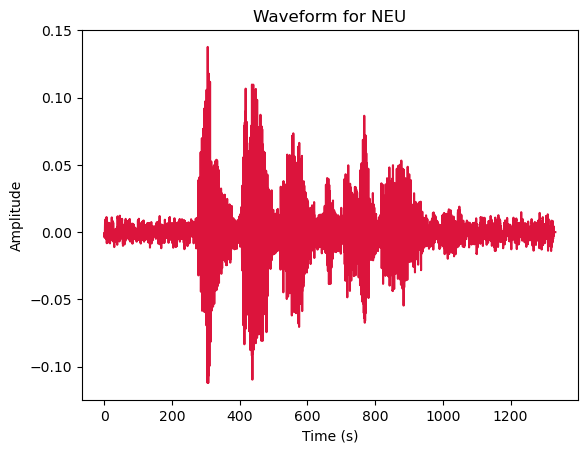

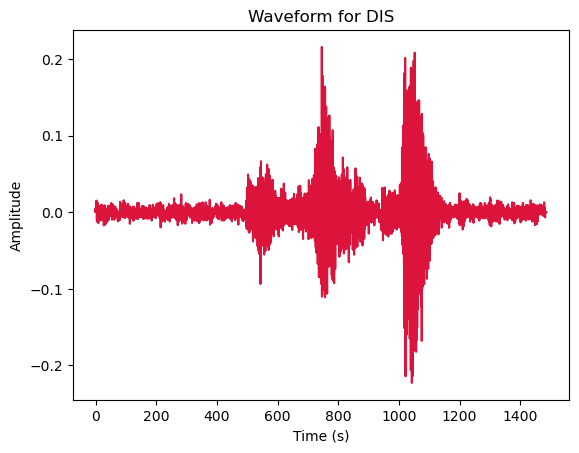

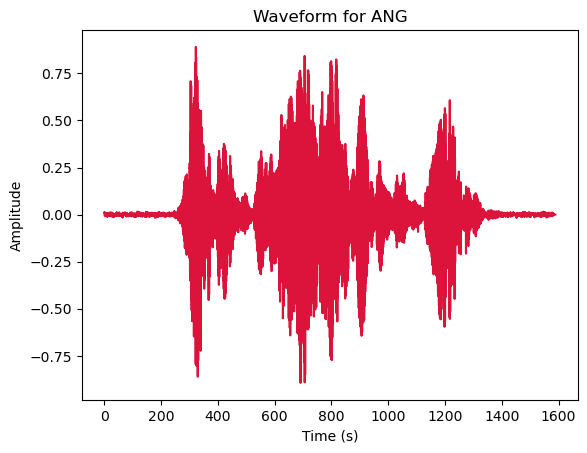

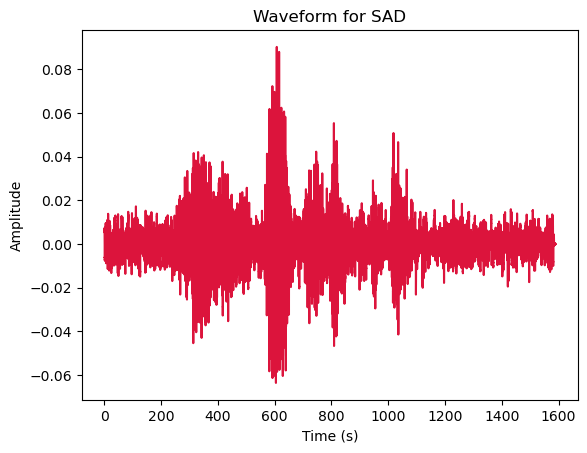

'\nEmotions depicted below in order\n1.Fear\n2.Disgust\n3.Happy\n4.Anger\n5.Sad\n6.Neutral\n'

In [12]:
samples(audio_df)
audio_df

'''
Emotions depicted below in order
1.Fear
2.Disgust
3.Happy
4.Anger
5.Sad
6.Neutral
'''

In [9]:
audio_arrays = []

for i in audio_df['file_path']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
audio_df['Arrays'] = audio_arrays
audio_df

,file_path,label,Arrays
0,/kaggle/input/speech-emotion-recognition-en/Cr...,DIS,"[0.0051987115, 0.0067456197, 0.0065078777, 0.0..."
1,/kaggle/input/speech-emotion-recognition-en/Cr...,HAP,"[-0.0054751206, -0.00713885, -0.0067585437, -0..."
2,/kaggle/input/speech-emotion-recognition-en/Cr...,HAP,"[-2.10721e-05, 0.00013225194, 0.00036462393, 0..."
3,/kaggle/input/speech-emotion-recognition-en/Cr...,DIS,"[0.0027296818, 0.0025122813, 0.0009894323, 4.4..."
4,/kaggle/input/speech-emotion-recognition-en/Cr...,DIS,"[-0.0012989982, -0.0016537481, -0.0013569102, ..."
...,...,...,...
7437,/kaggle/input/speech-emotion-recognition-en/Cr...,ANG,"[0.006019091, 0.0075440574, 0.006769056, 0.006..."
7438,/kaggle/input/speech-emotion-recognition-en/Cr...,ANG,"[-0.00096016855, -0.001384086, -0.0015201073, ..."
7439,/kaggle/input/speech-emotion-recognition-en/Cr...,ANG,"[0.0013364321, 0.0017082326, 0.0018099947, 0.0..."
7440,/kaggle/input/speech-emotion-recognition-en/Cr...,SAD,"[0.0010454531, 0.0015660033, 0.0015824048, 0.0..."


In [10]:
# defining the functions for each emotions
def noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def pitch(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps=pitch_factor)

def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def ext_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=ext_features(data,sr)
    audio=np.array(aud)
    
    noised_audio=noise(data,random=True)
    aud2=ext_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr,random=True)
    aud3=ext_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))
    
    return audio

In [11]:
# Audio processing

X, Y = [], []

for path, emotion, index in zip(audio_df.file_path, audio_df.label, range(audio_df.file_path.shape[0])):
    features = get_features(path)
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)

print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
Done


In [12]:
processed_data_path='./processed_data.csv'

In [13]:
# Extracting features from audio

ext=pd.DataFrame(X)
ext['label']=Y
ext.to_csv(processed_data_path,index=False)
ext.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,label
0,0.122070,0.187988,0.235840,0.249512,0.249512,0.245605,0.237305,0.183594,0.124512,0.073730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
1,0.121094,0.187500,0.234863,0.252441,0.252441,0.248535,0.245117,0.189453,0.132324,0.081543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
2,0.117676,0.164551,0.214844,0.236816,0.241699,0.252441,0.230957,0.170410,0.110840,0.064453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS
3,0.016113,0.021484,0.029297,0.030762,0.033691,0.036133,0.038574,0.046875,0.054688,0.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
4,0.018066,0.024414,0.033203,0.033691,0.037598,0.038086,0.041504,0.049805,0.055664,0.064453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
5,0.017578,0.024902,0.035156,0.036621,0.039551,0.039062,0.043945,0.049316,0.057129,0.064453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
6,0.013184,0.020020,0.026855,0.028809,0.026855,0.031250,0.036133,0.040527,0.050293,0.054199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
7,0.207520,0.322266,0.429199,0.425293,0.429688,0.423340,0.417969,0.356934,0.301758,0.238281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
8,0.012207,0.022461,0.035156,0.041992,0.041016,0.049316,0.044922,0.052246,0.064453,0.075195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAP
9,0.016113,0.024902,0.033203,0.034668,0.042480,0.043457,0.042480,0.040039,0.030762,0.028809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIS


In [14]:
# searching for null values
df=pd.read_csv(processed_data_path)
df.shape

df=df.fillna(0)
print(df.isna().any())
df.shape

0        False
1        False
2        False
3        False
4        False
         ...  
2372     False
2373     False
2374     False
2375     False
label    False
Length: 2377, dtype: bool


(22326, 2377)

In [24]:
# Label encoding
X = df.drop('label', axis=1)
Y = df['label']
lb = LabelEncoder()
Y=np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [25]:
# Train test split into training and validation

X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=32,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=32,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape


scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((16074, 2376), (4466, 2376), (1786, 2376), (16074, 6), (4466, 6), (1786, 6))

In [26]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((16074, 2376, 1), (4466, 2376, 1), (1786, 2376, 1))

### Adding CNN layers to the data

In [27]:
model = Sequential()

# Convolutional layers
model.add(keras.layers.Conv1D(256, kernel_size=5, strides=1, activation='linear', input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=5, strides = 2))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))

# Flatten and fully connected layers
model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.7))

model.add(keras.layers.Dense(256, activation='linear'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))


model.add(keras.layers.Dense(6))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('softmax')) 

# Optimizer and compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2372, 256)         1536      
                                                                 
 batch_normalization (BatchN  (None, 2372, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2372, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2368, 128)         163968    
                                                                 
 batch_normalization_1 (Batc  (None, 2368, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 2368, 128)         0

In [36]:
# Define the callbacks
early_stopping = callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss', verbose=1)

# Train the model
warnings.filterwarnings("ignore")
history = model.fit(X_train, y_train, epochs=15, batch_size=32,
                    validation_data=(X_val,y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/15
503/503 [==============================] - 53s 106ms/step - loss: 1.0933 - accuracy: 0.6057 - val_loss: 1.1872 - val_accuracy: 0.5515 - lr: 1.0000e-04
Epoch 2/15
503/503 [==============================] - 52s 103ms/step - loss: 1.0560 - accuracy: 0.6237 - val_loss: 1.1202 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 3/15
503/503 [==============================] - 53s 106ms/step - loss: 1.0116 - accuracy: 0.6412 - val_loss: 1.1353 - val_accuracy: 0.5907 - lr: 1.0000e-04
Epoch 4/15
503/503 [==============================] - 52s 104ms/step - loss: 0.9760 - accuracy: 0.6628 - val_loss: 1.0334 - val_accuracy: 0.6265 - lr: 1.0000e-04
Epoch 5/15
503/503 [==============================] - 53s 106ms/step - loss: 0.9395 - accuracy: 0.6784 - val_loss: 1.0392 - val_accuracy: 0.6209 - lr: 1.0000e-04
Epoch 6/15
503/503 [==============================] - 52s 104ms/step - loss: 0.9001 - accuracy: 0.6981 - val_loss: 1.0477 - val_accuracy: 0.6025 - lr: 1.0000e-04
Epoch 7/15
503/503 [========

In [37]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 65.88%


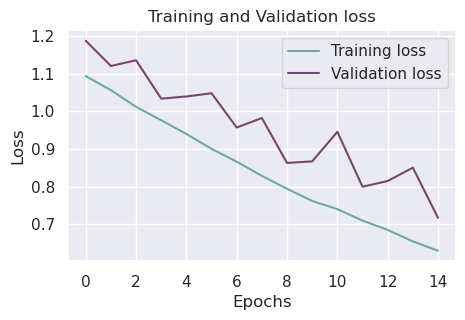

In [38]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

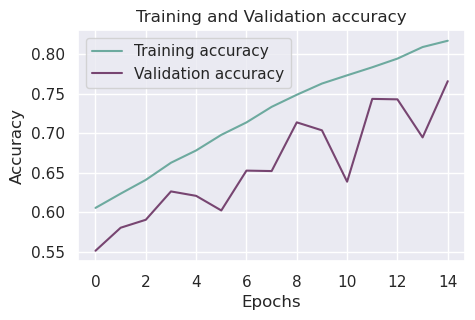

In [39]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

140/140 [==============================] - 4s 28ms/step


In [41]:
c_emotions = {
    'NEU':'neutral',
    'HAP':'happy',
    'SAD':'sad',
    'ANG':'angry',
    'FEA':'fear',
    'DIS':'disgust'}

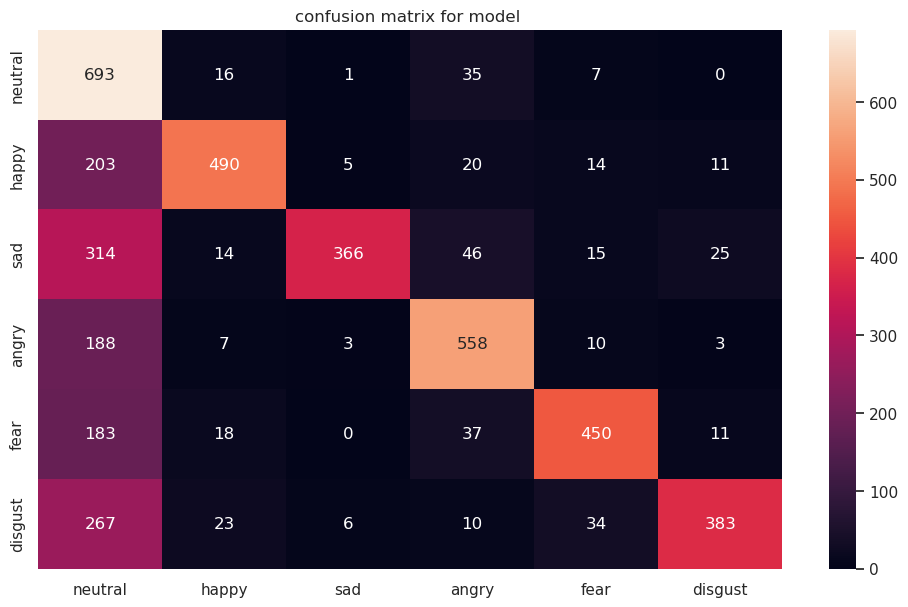

In [42]:
import seaborn as sns
# confusion matrix
y_test_Label = np.argmax(y_test, axis=1)
y_pred_Label = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test_Label,y_pred_Label)
cmap1 = sns.diverging_palette(275,100,  s=40, l=65, n=6)
cm=pd.DataFrame(
    conf,index=[i for i in c_emotions.values()],
    columns=[i for i in c_emotions.values()]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()